In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Objective:
Use content based filtering algorithm to make a **Movie Recommender System**.

# Loading the Data:

# 1.Loading the Ratings of user on individual movies:

In [2]:
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [3]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
ratings.drop(columns=['timestamp'], inplace=True)

# Loading the movie details:

In [5]:
# Loading movie Data
movies = pd.read_csv(
    'u.item',
    sep='|',
    encoding='latin-1',
    names=[
        'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
        'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
        'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
    ])

In [6]:
movies.drop(columns=['video_release_date'], inplace=True)

In [7]:
movies.head()

,movie_id,title,release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Mapping the Genres:

In [8]:
with open('u.genre', 'r') as f:
    genres = f.readlines()

# Convert to dictionary
genre_map = {line.split('|')[0]: int(line.split('|')[1]) for line in genres if '|' in line}
print(genre_map)

{'unknown': 0, 'Action': 1, 'Adventure': 2, 'Animation': 3, "Children's": 4, 'Comedy': 5, 'Crime': 6, 'Documentary': 7, 'Drama': 8, 'Fantasy': 9, 'Film-Noir': 10, 'Horror': 11, 'Musical': 12, 'Mystery': 13, 'Romance': 14, 'Sci-Fi': 15, 'Thriller': 16, 'War': 17, 'Western': 18}


# Loading the user Information:

In [9]:
users = pd.read_csv(
    'u.user',
    sep='|',
    names=['user_id', 'age', 'gender', 'occupation', 'zip_code']
)

In [10]:
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


# Checking for Missing Values:

In [11]:
print("Missing values in ratings:")
print(ratings.isnull().sum())

Missing values in ratings:
user_id     0
movie_id    0
rating      0
dtype: int64


In [12]:
print("\nMissing values in movies:")
print(movies.isnull().sum())


Missing values in movies:
movie_id        0
title           0
release_date    1
IMDb_URL        3
unknown         0
Action          0
Adventure       0
Animation       0
Children's      0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
dtype: int64


In [13]:
print("\nMissing values in users:")
print(users.isnull().sum())


Missing values in users:
user_id       0
age           0
gender        0
occupation    0
zip_code      0
dtype: int64


In [14]:
print("Empty strings in ratings:")
print((ratings == '').sum())

Empty strings in ratings:
user_id     0
movie_id    0
rating      0
dtype: int64


In [15]:
print("\nEmpty strings in movies:")
print((movies == '').sum())


Empty strings in movies:
movie_id        0
title           0
release_date    0
IMDb_URL        0
unknown         0
Action          0
Adventure       0
Animation       0
Children's      0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
dtype: int64


In [16]:
print("\nEmpty strings in users:")
print((users == '').sum())


Empty strings in users:
user_id       0
age           0
gender        0
occupation    0
zip_code      0
dtype: int64


# Feature Engineering:

1. **Finding the average rating for each Genre for each User**

In [17]:
# Merge ratings with movies to get genre info
ratings_with_genres = pd.merge(ratings, movies, on='movie_id')

# Melt the genre columns into long format
genre_columns = [
    'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

melted = ratings_with_genres.melt(
    id_vars=['user_id', 'rating'],
    value_vars=genre_columns,
    var_name='genre',
    value_name='is_genre'
)

# Keep only the rows where genre applies (i.e., is_genre == 1)
melted = melted[melted['is_genre'] == 1]

# Group by user and genre, then take average rating
user_genre_avg = melted.groupby(['user_id', 'genre'])['rating'].mean().reset_index()

# Pivot to wide format so each genre becomes a column
user_genre_matrix = user_genre_avg.pivot(index='user_id', columns='genre', values='rating')

In [18]:
# Merge into users dataframe
users = users.merge(user_genre_matrix, on='user_id', how='left')

In [19]:
users.head()

,user_id,age,gender,occupation,zip_code,Action,Adventure,Animation,Children's,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown
0,1,24,M,technician,85711,3.333333,2.928571,3.333333,2.200000,3.472527,...,5.0,3.461538,2.923077,3.600000,3.931818,4.000000,3.615385,3.680000,3.666667,4.0
1,2,53,F,other,94043,3.800000,4.333333,4.000000,3.000000,3.812500,...,4.5,3.000000,3.000000,3.500000,4.125000,3.750000,3.583333,3.666667,NaN,NaN
2,3,23,M,writer,32067,2.785714,3.500000,NaN,NaN,2.583333,...,2.5,2.400000,2.000000,3.181818,3.400000,2.750000,2.523810,2.800000,NaN,NaN
3,4,24,M,technician,43537,3.875000,3.500000,NaN,NaN,5.000000,...,NaN,4.000000,5.000000,4.000000,4.333333,3.833333,3.909091,4.500000,NaN,NaN
4,5,33,F,other,15213,3.142857,3.242424,3.785714,2.448276,3.000000,...,5.0,2.535714,3.333333,3.000000,2.315789,3.515152,2.947368,3.214286,2.500000,4.0


In [20]:
# Calculate each user's overall average rating
user_avg = ratings.groupby('user_id')['rating'].mean()

# Fill NaNs in each row with that user's average
for genre in user_genre_matrix.columns:
    users[genre] = users[genre].fillna(users['user_id'].map(user_avg))

In [21]:
users.head()

,user_id,age,gender,occupation,zip_code,Action,Adventure,Animation,Children's,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown
0,1,24,M,technician,85711,3.333333,2.928571,3.333333,2.200000,3.472527,...,5.000000,3.461538,2.923077,3.600000,3.931818,4.000000,3.615385,3.680000,3.666667,4.000000
1,2,53,F,other,94043,3.800000,4.333333,4.000000,3.000000,3.812500,...,4.500000,3.000000,3.000000,3.500000,4.125000,3.750000,3.583333,3.666667,3.709677,3.709677
2,3,23,M,writer,32067,2.785714,3.500000,2.796296,2.796296,2.583333,...,2.500000,2.400000,2.000000,3.181818,3.400000,2.750000,2.523810,2.800000,2.796296,2.796296
3,4,24,M,technician,43537,3.875000,3.500000,4.333333,4.333333,5.000000,...,4.333333,4.000000,5.000000,4.000000,4.333333,3.833333,3.909091,4.500000,4.333333,4.333333
4,5,33,F,other,15213,3.142857,3.242424,3.785714,2.448276,3.000000,...,5.000000,2.535714,3.333333,3.000000,2.315789,3.515152,2.947368,3.214286,2.500000,4.000000


In [22]:
print("\nMissing values in users:")
print(users.isnull().sum())


Missing values in users:
user_id        0
age            0
gender         0
occupation     0
zip_code       0
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
unknown        0
dtype: int64


**Adding the average rating for each movie**

In [23]:
# Calculate average rating per movie
movie_avg_rating = ratings.groupby('movie_id')['rating'].mean().reset_index()
movie_avg_rating.rename(columns={'rating': 'avg_rating'}, inplace=True)

# Merge with movies DataFrame
movies = movies.merge(movie_avg_rating, on='movie_id', how='left')

# Check result
print(movies[['movie_id', 'title', 'avg_rating']].head())

   movie_id              title  avg_rating
0         1   Toy Story (1995)    3.878319
1         2   GoldenEye (1995)    3.206107
2         3  Four Rooms (1995)    3.033333
3         4  Get Shorty (1995)    3.550239
4         5     Copycat (1995)    3.302326


In [24]:
print("\nMissing values in movies:")
print(movies.isnull().sum())


Missing values in movies:
movie_id        0
title           0
release_date    1
IMDb_URL        3
unknown         0
Action          0
Adventure       0
Animation       0
Children's      0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
avg_rating      0
dtype: int64


In [25]:
users.columns

Index(['user_id', 'age', 'gender', 'occupation', 'zip_code', 'Action',
       'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'unknown'],
      dtype='object')

In [26]:
movies.columns

Index(['movie_id', 'title', 'release_date', 'IMDb_URL', 'unknown', 'Action',
       'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'avg_rating'],
      dtype='object')

# Copy DataFrames for Referances:

In [27]:
user_info = users[['user_id', 'age', 'gender', 'occupation', 'zip_code']].copy()

In [28]:
movie_info = movies[['movie_id', 'title', 'release_date', 'IMDb_URL'] + genre_columns].copy()

In [29]:
# Generate a genres column
def extract_genres(row):
    return [genre for genre in genre_columns if row[genre] == 1]

movie_info['genres'] = movie_info.apply(extract_genres, axis=1)

# Step 4 (optional): Drop the individual genre columns to keep only the list
movie_info.drop(columns=genre_columns, inplace=True)

In [30]:
user_info.head(3)

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067


In [31]:
movie_info.head(3)

,movie_id,title,release_date,IMDb_URL,genres
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,[Thriller]


# Preparing the Training Set:

In [32]:
# One-hot encode 'occupation' in the full users dataframe
users = pd.get_dummies(users, columns=['occupation'])

# Get all columns that start with 'occupation_' 
occupation_columns = [col for col in users.columns if col.startswith('occupation_')]

In [33]:
# Merge user features
user_feature_cols = ['user_id', 'age', 'gender'] + [
    'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'unknown'
] + occupation_columns

X_users = ratings.merge(users[user_feature_cols], on='user_id', how='left')

In [34]:
# Merge movie features
movie_feature_cols = ['movie_id', 'avg_rating'] + [
    'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'unknown'
]

X_movies = ratings.merge(movies[movie_feature_cols], on='movie_id', how='left')

In [35]:
# Extract target labels
y = ratings['rating'].copy()

In [36]:
X_users = X_users.drop(columns=['movie_id', 'rating'], errors='ignore')
X_movies = X_movies.drop(columns=['user_id', 'rating'], errors='ignore')

In [37]:
# Convert boolean columns to int (0/1) in X_users
X_users = X_users.astype({col: int for col in X_users.columns if X_users[col].dtype == bool})

# Convert boolean columns to int (0/1) in users
users = users.astype({col: int for col in users.columns if users[col].dtype == bool})

In [38]:
X_users.head(3)

,user_id,age,gender,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,196,49,M,1.666667,2.500000,3.615385,4.00,3.562500,3.615385,4.000000,...,0,0,0,0,0,0,0,0,0,1
1,186,39,F,3.566667,3.461538,3.600000,3.40,3.000000,2.846154,3.413043,...,0,0,0,0,0,0,0,0,0,0
2,22,25,M,3.772727,3.457143,3.351562,1.25,2.986111,4.000000,3.351562,...,0,0,0,0,0,0,0,0,0,1


In [39]:
X_movies.head(3)

,movie_id,avg_rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown
0,242,3.991453,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,302,4.161616,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
2,377,2.153846,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X_users.columns

Index(['user_id', 'age', 'gender', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'unknown', 'occupation_administrator',
       'occupation_artist', 'occupation_doctor', 'occupation_educator',
       'occupation_engineer', 'occupation_entertainment',
       'occupation_executive', 'occupation_healthcare', 'occupation_homemaker',
       'occupation_lawyer', 'occupation_librarian', 'occupation_marketing',
       'occupation_none', 'occupation_other', 'occupation_programmer',
       'occupation_retired', 'occupation_salesman', 'occupation_scientist',
       'occupation_student', 'occupation_technician', 'occupation_writer'],
      dtype='object')

In [41]:
X_movies.columns

Index(['movie_id', 'avg_rating', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'unknown'],
      dtype='object')

In [42]:
gender_map = {'M': 0, 'F': 1}

users['gender'] = users['gender'].map(gender_map)
X_users['gender'] = X_users['gender'].map(gender_map)

In [43]:
users.drop(columns = ["zip_code"], inplace = True)

In [44]:
movies.drop(columns = ['title', 'release_date', 'IMDb_URL'], inplace = True)

In [45]:
# Drop IDs from training sets
X_users.drop(columns=['user_id'], inplace=True)
X_movies.drop(columns=['movie_id'], inplace=True)

# Drop IDs from testing sets 
users.drop(columns=['user_id'], inplace=True)
movies.drop(columns=['movie_id'], inplace=True)

# Verifying the prepared columns:

In [46]:
assert len(X_users) == len(X_movies) == len(y), "Mismatch in training set sizes"

In [47]:
# Check for null values
assert not X_users.isnull().any().any(), "X_users has missing values"
assert not X_movies.isnull().any().any(), "X_movies has missing values"
assert not y.isnull().any(), "y has missing values"
assert not users.isnull().any().any(), "users has missing values"
assert not movies.isnull().any().any(), "movies has missing values"

In [48]:
assert set(users['gender'].unique()).issubset({0, 1}), "Invalid gender values in users"
assert set(X_users['gender'].unique()).issubset({0, 1}), "Invalid gender values in X_users"

In [49]:
assert all([np.issubdtype(dtype, np.number) for dtype in X_users.dtypes]), "X_users has non-numeric columns"
assert all([np.issubdtype(dtype, np.number) for dtype in X_movies.dtypes]), "X_movies has non-numeric columns"

In [50]:
assert 'user_id' not in X_users.columns, "user_id should not be in X_users"
assert 'movie_id' not in X_movies.columns, "movie_id should not be in X_movies"

In [51]:
print(user_info.columns)  # should include: user_id, age, gender, occupation, zip_code
print(movie_info.columns) # should include: movie_id, title, release_date, IMDb_URL, genre (as single string or list)

Index(['user_id', 'age', 'gender', 'occupation', 'zip_code'], dtype='object')
Index(['movie_id', 'title', 'release_date', 'IMDb_URL', 'genres'], dtype='object')


In [52]:
X_users.head(2)

,age,gender,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,49,0,1.666667,2.500000,3.615385,4.0,3.5625,3.615385,4.000000,4.090909,...,0,0,0,0,0,0,0,0,0,1
1,39,1,3.566667,3.461538,3.600000,3.4,3.0000,2.846154,3.413043,3.560000,...,0,0,0,0,0,0,0,0,0,0


In [53]:
users.head(2)

,age,gender,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,24,0,3.333333,2.928571,3.333333,2.2,3.472527,3.440000,4.800000,3.925234,...,0,0,0,0,0,0,0,0,1,0
1,53,1,3.800000,4.333333,4.000000,3.0,3.812500,3.777778,3.709677,3.828571,...,0,0,1,0,0,0,0,0,0,0


In [54]:
X_movies.head(2)

,avg_rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown
0,3.991453,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.161616,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0


In [55]:
movies.head(2)

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,avg_rating
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.878319
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.206107


In [56]:
movies = movies[X_movies.columns]

In [57]:
user_info.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [58]:
movie_info.head()

,movie_id,title,release_date,IMDb_URL,genres
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,[Thriller]
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,"[Action, Comedy, Drama]"
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),"[Crime, Drama, Thriller]"


In [59]:
# Compare Shapes
assert X_users.shape[1] == users.shape[1], "Mismatch in number of columns between X_users and users"
assert X_movies.shape[1] == movies.shape[1], "Mismatch in number of columns between X_movies and movies"

In [60]:
# Compare Order
assert list(X_users.columns) == list(users.columns), "Column names or order mismatch in users"
assert list(X_movies.columns) == list(movies.columns), "Column names or order mismatch in movies"

In [61]:
# Compare datatypes
assert all(X_users.dtypes == users.dtypes), "Mismatch in data types between X_users and users"
assert all(X_movies.dtypes == movies.dtypes), "Mismatch in data types between X_movies and movies"

# Some Exploratory Data Analysis:

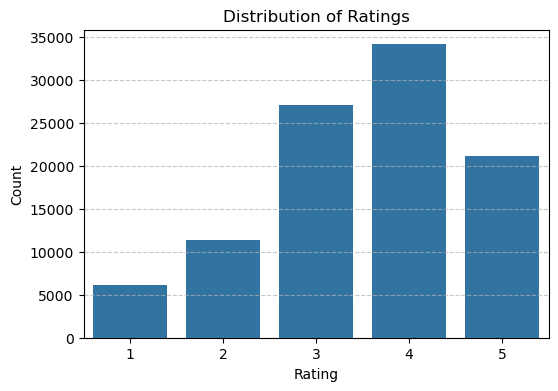

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [62]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(y.describe())

1. Most of the users has given the ratings in range **3-5**.
2. **4** is given by most users, then **3**, **5**, **2** and least of the users gave **1**.

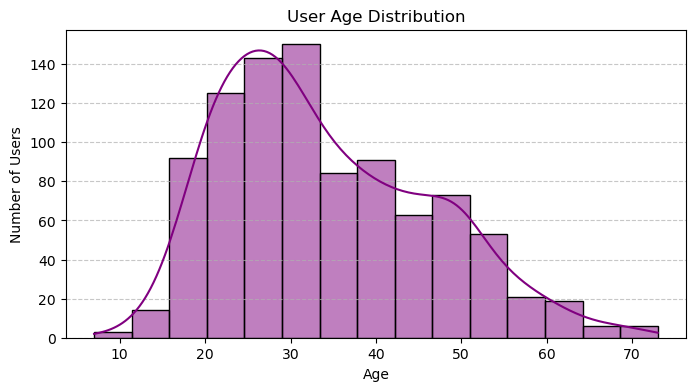

In [63]:
plt.figure(figsize=(8, 4))
sns.histplot(users['age'], bins=15, kde=True, color='purple')
plt.title("User Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Users")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. The age is ranging from **10-70**, There are more but 99% are in this range.
2. Most of the people are of age between **15-35**.
3. There are rarely any people below **15** and above **60**.

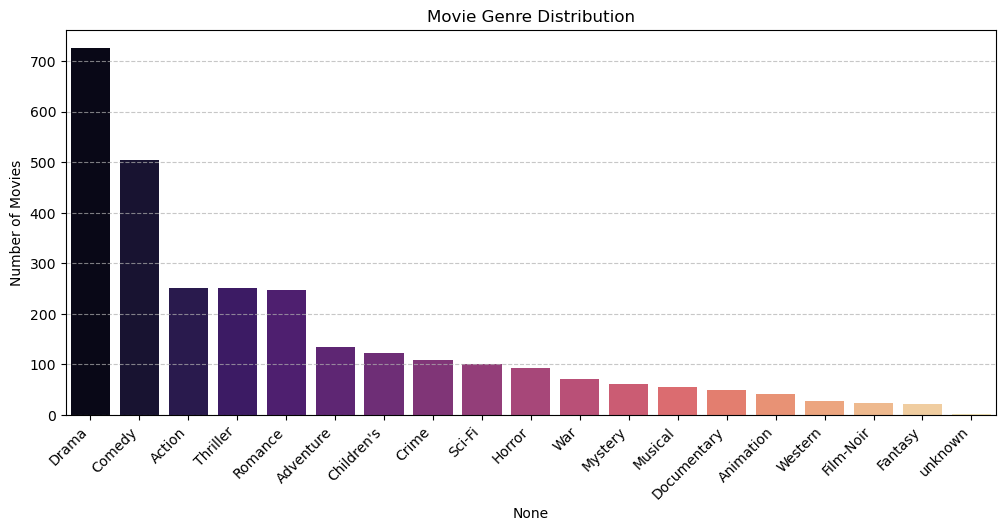

In [64]:
genre_cols = [col for col in movies.columns if col not in ['avg_rating']]
genre_counts = movies[genre_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(
    x=genre_counts.index,
    y=genre_counts.values,
    hue=genre_counts.index,          # Use genre as hue
    palette='magma',
    legend=False                     # Hide redundant legend
)
plt.xticks(rotation=45, ha='right')
plt.title("Movie Genre Distribution")
plt.ylabel("Number of Movies")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. **Drama** is the most popular Genre with over *700 Movies*.
2. **Comedy** comes at second with over *500 Movies*.
3. Then comes **Action**, **Thriller** and **Romance** with almost equal number of movies. Then comes the rest.
4. There are almost no movies of **unknown** genre as compared to others.

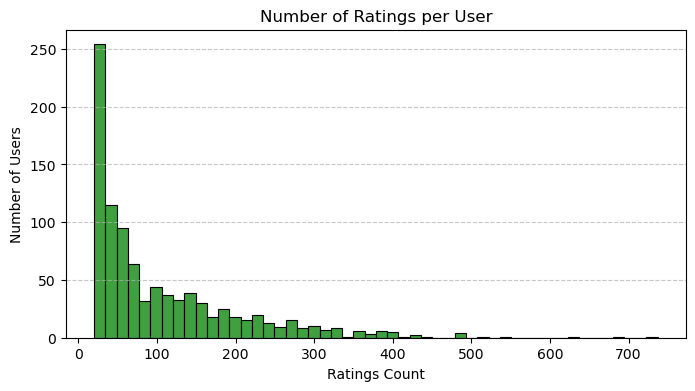

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: count, dtype: float64


In [65]:
ratings_per_user = ratings['user_id'].value_counts()

plt.figure(figsize=(8, 4))
sns.histplot(ratings_per_user, bins=50, kde=False, color='green')
plt.title("Number of Ratings per User")
plt.xlabel("Ratings Count")
plt.ylabel("Number of Users")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(ratings_per_user.describe())

1. Most of the users have rated **100** or less movies.
2. Moderate number if users have rated under **300** movies.
3. Very less users have rated movies under **400**.
4. Then there are outliers till **750**.

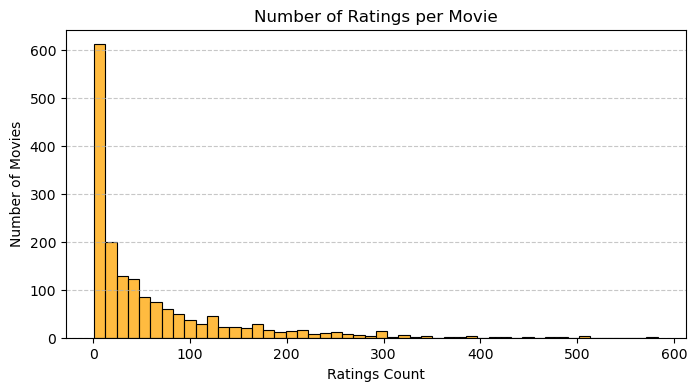

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: count, dtype: float64


In [66]:
ratings_per_movie = ratings['movie_id'].value_counts()

plt.figure(figsize=(8, 4))
sns.histplot(ratings_per_movie, bins=50, kde=False, color='orange')
plt.title("Number of Ratings per Movie")
plt.xlabel("Ratings Count")
plt.ylabel("Number of Movies")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(ratings_per_movie.describe())

1. Most of the movies have less than or equal to **100** ratings.
2. Very small number of movies have under **300** ratings.
3. Then there are outliers till **600**.

# Scaling Some Features:

In [67]:
from sklearn.preprocessing import MinMaxScaler

In [68]:
scaler = MinMaxScaler()

# For age
age_scaler = MinMaxScaler()
X_users['age'] = age_scaler.fit_transform(X_users[['age']])
users['age'] = age_scaler.transform(users[['age']])

# For avg_rating
rating_scaler = MinMaxScaler()
X_movies['avg_rating'] = rating_scaler.fit_transform(X_movies[['avg_rating']])
movies['avg_rating'] = rating_scaler.transform(movies[['avg_rating']])

In [69]:
genre_cols = [
    'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'unknown'
]

# For genre columns
genre_scaler = MinMaxScaler()
X_users[genre_cols] = genre_scaler.fit_transform(X_users[genre_cols])
users[genre_cols] = genre_scaler.transform(users[genre_cols])

In [70]:
def print_column_ranges(df, name):
    print(f"\nRanges for {name}:")
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            min_val = df[col].min()
            max_val = df[col].max()
            print(f"{col:25} ➤ min: {min_val:.3f}, max: {max_val:.3f}")
        else:
            print(f"{col:25} ➤ dtype: {df[col].dtype}")

print_column_ranges(X_users, "X_users")
print_column_ranges(X_movies, "X_movies")


Ranges for X_users:
age                       ➤ min: 0.000, max: 1.000
gender                    ➤ min: 0.000, max: 1.000
Action                    ➤ min: 0.000, max: 1.000
Adventure                 ➤ min: 0.000, max: 1.000
Animation                 ➤ min: 0.000, max: 1.000
Children's                ➤ min: 0.000, max: 1.000
Comedy                    ➤ min: 0.000, max: 1.000
Crime                     ➤ min: 0.000, max: 1.000
Documentary               ➤ min: 0.000, max: 1.000
Drama                     ➤ min: 0.000, max: 1.000
Fantasy                   ➤ min: 0.000, max: 1.000
Film-Noir                 ➤ min: 0.000, max: 1.000
Horror                    ➤ min: 0.000, max: 1.000
Musical                   ➤ min: 0.000, max: 1.000
Mystery                   ➤ min: 0.000, max: 1.000
Romance                   ➤ min: 0.000, max: 1.000
Sci-Fi                    ➤ min: 0.000, max: 1.000
Thriller                  ➤ min: 0.000, max: 1.000
War                       ➤ min: 0.000, max: 1.000
Western   

# Splitting the data into Training, Cross Validation and Test Sets.

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
# First, split into train and temp (30% to be split later into val + test)
X_users_train, X_users_temp, X_movies_train, X_movies_temp, y_train, y_temp = train_test_split(
    X_users, X_movies, y, test_size=0.30, random_state=42
)

# Then split temp into val and test
X_users_val, X_users_test, X_movies_val, X_movies_test, y_val, y_test = train_test_split(
    X_users_temp, X_movies_temp, y_temp, test_size=0.50, random_state=42
)

# Verifying Splits:

In [73]:
print(f"Total samples       : {len(X_users)}")
print(f"Train samples       : {len(X_users_train)}")
print(f"Validation samples  : {len(X_users_val)}")
print(f"Test samples        : {len(X_users_test)}")

Total samples       : 100000
Train samples       : 70000
Validation samples  : 15000
Test samples        : 15000


In [74]:
assert len(X_users_train) == len(X_movies_train) == len(y_train)
assert len(X_users_val) == len(X_movies_val) == len(y_val)
assert len(X_users_test) == len(X_movies_test) == len(y_test)

In [75]:
# Optional: Mean rating per split
print("\nMean rating per split:")
print(f"Train      : {y_train.mean():.3f}")
print(f"Validation : {y_val.mean():.3f}")
print(f"Test       : {y_test.mean():.3f}")


Mean rating per split:
Train      : 3.530
Validation : 3.531
Test       : 3.527


# Saving Preprocessed Data to Disk:

In [76]:
# Save train sets
X_users_train.to_parquet("X_users_train.parquet")
X_movies_train.to_parquet("X_movies_train.parquet")
y_train.to_frame(name='rating').to_parquet("y_train.parquet")

# Save validation sets
X_users_val.to_parquet("X_users_val.parquet")
X_movies_val.to_parquet("X_movies_val.parquet")
y_val.to_frame(name='rating').to_parquet("y_val.parquet")

# Save test sets
X_users_test.to_parquet("X_users_test.parquet")
X_movies_test.to_parquet("X_movies_test.parquet")
y_test.to_frame(name='rating').to_parquet("y_test.parquet")

# Save reference data
user_info.to_parquet("user_info.parquet")
movie_info.to_parquet("movie_info.parquet")

# Save for embedding/lookup reference
users.to_parquet("users.parquet")
movies.to_parquet("movies.parquet")

# Reading Preprocessed Data from Disk:

In [2]:
# Load train sets
X_users_train = pd.read_parquet("X_users_train.parquet")
X_movies_train = pd.read_parquet("X_movies_train.parquet")
y_train = pd.read_parquet("y_train.parquet")['rating']

# Load validation sets
X_users_val = pd.read_parquet("X_users_val.parquet")
X_movies_val = pd.read_parquet("X_movies_val.parquet")
y_val = pd.read_parquet("y_val.parquet")['rating']

# Load test sets
X_users_test = pd.read_parquet("X_users_test.parquet")
X_movies_test = pd.read_parquet("X_movies_test.parquet")
y_test = pd.read_parquet("y_test.parquet")['rating']

# Load reference data
user_info = pd.read_parquet("user_info.parquet")
movie_info = pd.read_parquet("movie_info.parquet")

# Load user/movie lookup data for embeddings or verification
users = pd.read_parquet("users.parquet")
movies = pd.read_parquet("movies.parquet")

# Verification:

In [78]:
X_users_train.head(2)

,age,gender,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
76513,0.272727,1,0.851852,0.883333,0.916667,0.857143,0.860606,0.972222,1.000000,0.876044,...,0,0,1,0,0,0,0,0,0,0
60406,0.272727,0,0.597403,0.611111,0.632353,0.583333,0.528256,0.703125,0.597588,0.635124,...,0,0,0,1,0,0,0,0,0,0


In [82]:
users.head(2)

,age,gender,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,0.257576,0,0.583333,0.482143,0.583333,0.3,0.583417,0.610000,0.950000,0.689145,...,0,0,0,0,0,0,0,0,1,0
1,0.696970,1,0.700000,0.833333,0.750000,0.5,0.676136,0.694444,0.677419,0.661187,...,0,0,1,0,0,0,0,0,0,0


In [84]:
movies.head(2)

,avg_rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown
0,0.719580,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.551527,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [87]:
X_movies_train.head(2)

,avg_rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown
76513,0.628698,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
60406,0.595000,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [85]:
user_info.head(2)

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [86]:
movie_info.head(2)

,movie_id,title,release_date,IMDb_URL,genres
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"[Action, Adventure, Thriller]"


In [49]:
print(y_train.dtype)
print(y_train.min(), y_train.max())
print(np.unique(y_train))

int64
1 5
[1 2 3 4 5]


In [50]:
print(X_users_train.shape, X_movies_train.shape)
print(X_users_train[:2])
print(X_movies_train[:2])

(70000, 42) (70000, 20)
            age  gender    Action  Adventure  Animation  Children's    Comedy  \
76513  0.272727       1  0.851852   0.883333   0.916667    0.857143  0.860606   
60406  0.272727       0  0.597403   0.611111   0.632353    0.583333  0.528256   

          Crime  Documentary     Drama  ...  occupation_marketing  \
76513  0.972222     1.000000  0.876044  ...                     0   
60406  0.703125     0.597588  0.635124  ...                     0   

       occupation_none  occupation_other  occupation_programmer  \
76513                0                 1                      0   
60406                0                 0                      1   

       occupation_retired  occupation_salesman  occupation_scientist  \
76513                   0                    0                     0   
60406                   0                    0                     0   

       occupation_student  occupation_technician  occupation_writer  
76513                   0          

# Training Neural Network:

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [13]:
from sklearn.metrics import mean_squared_error

In [51]:
# Feature dimensions
user_feature_dim = X_users_train.shape[1]
movie_feature_dim = X_movies_train.shape[1]

In [11]:
# User model
user_input = Input(shape=(X_users_train.shape[1],), name='user_input')
x = Dense(256, activation='relu')(user_input)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dense(32)(x)
vu = Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

# Movie model
movie_input = Input(shape=(X_movies_train.shape[1],), name='movie_input')
y = Dense(256, activation='relu')(movie_input)
y = BatchNormalization()(y)
y = Dropout(0.4)(y)
y = Dense(128, activation='relu')(y)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)
y = Dense(32)(y)
vm = Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(y)

# Dot product → final rating prediction
dot_product = Dot(axes=1)([vu, vm])
output = Dense(1, activation='linear')(dot_product)

In [12]:
# Compile model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 42)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_input (InputLayer)      │ (None, 20)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (None, 256)               │          11,008 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_21 (Dense)              │ (None, 256)               │           5,376 │ movie_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_5         │ (None, 256)               │           1,024 │ dense_17[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_6         │ (None, 256)               │           1,024 │ dense_21[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 256)               │               0 │ batch_normalization_5[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 256)               │               0 │ batch_normalization_6[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 128)               │          32,896 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_22 (Dense)              │ (None, 128)               │          32,896 │ dropout_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 128)               │               0 │ dense_18[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 128)               │               0 │ dense_22[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_19 (Dense)              │ (None, 64)                │           8,256 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_23 (Dense)              │ (None, 64)                │           8,256 │ dropout_12[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 32)                │           2,080 │ dense_19[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_24 (Dense)              │ (None, 32)                │           2,080 │ dense_23[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 104,898 (409.76 KB)

 Trainable params: 103,874 (405.76 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [16]:
# Early stopping
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [17]:
# Fit model
history = model.fit(
    x=[X_users_train, X_movies_train],
    y=y_train,
    validation_data=([X_users_val, X_movies_val], y_val),
    batch_size=256,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8073 - mae: 0.7107 - val_loss: 0.8210 - val_mae: 0.7147
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8091 - mae: 0.7117 - val_loss: 0.8210 - val_mae: 0.7135
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8062 - mae: 0.7101 - val_loss: 0.8197 - val_mae: 0.7189
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8046 - mae: 0.7099 - val_loss: 0.8190 - val_mae: 0.7123
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8049 - mae: 0.7091 - val_loss: 0.8144 - val_mae: 0.7143
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8035 - mae: 0.7091 - val_loss: 0.8173 - val_mae: 0.7161
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8044 - mae: 0.7090 - val_loss: 0.8173 - val_mae: 0.7156
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8048 - mae: 0.7094 - val_loss: 0.8209 - val_mae: 0.7134
Epoch 9/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/

# Model Evaluation:

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
# ========== 1. Plot Training History ==========
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # MAE Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE', color='green')
    plt.plot(history.history['val_mae'], label='Val MAE', color='red')
    plt.title('Model MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

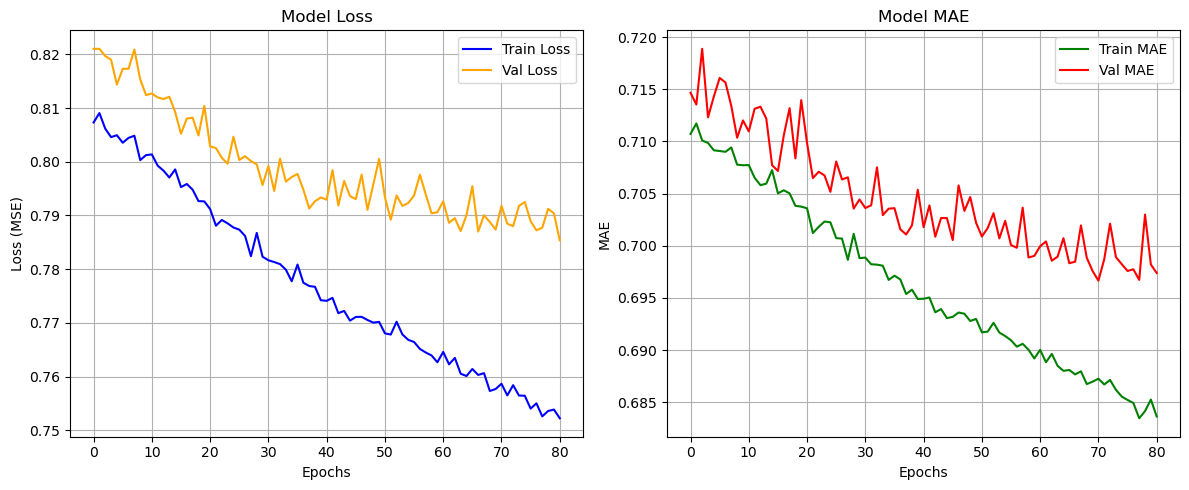

In [20]:
plot_training_history(history)

In [21]:
# ========== 2. Evaluate on Test Set ==========
print("Evaluating model on test data...\n")
test_loss, test_mae = model.evaluate([X_users_test, X_movies_test], y_test, verbose=1)

print(f"\n✅ Test Loss (MSE): {test_loss:.4f}")
print(f"✅ Test MAE: {test_mae:.4f}")

Evaluating model on test data...

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7854 - mae: 0.6958

✅ Test Loss (MSE): 0.7854
✅ Test MAE: 0.6958


In [23]:
# ========== 3. Predict and Plot MAE Distribution ==========
print("\nMaking predictions on test set...")
y_pred = model.predict([X_users_test, X_movies_test]).flatten()

# Calculate errors
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"\n Mean Absolute Error: {mae:.4f}")
print(f" Mean Squared Error: {mse:.4f}")


Making predictions on test set...
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step    

 Mean Absolute Error: 0.6958
 Mean Squared Error: 0.7854


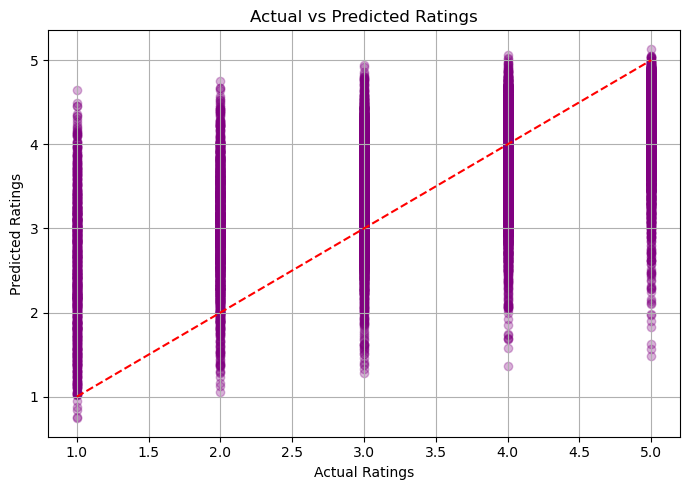

In [24]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.3, color='purple')
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.tight_layout()
plt.show()

# Save the Trained Model:

In [26]:
# Save the trained model
model.save("content_based_rating_predictor.h5")
print("✅ Model saved as 'content_based_rating_predictor.h5'")

✅ Model saved as 'content_based_rating_predictor.h5'


In [27]:
# Save the trained model
model.save("content_based_rating_predictor.keras")
print("✅ Model saved as 'content_based_rating_predictor.keras'")

✅ Model saved as 'content_based_rating_predictor.keras'
